# CT5134 Reinforcement Learning Assignment 2

<H3> <b> Name: Vikrant Singh Jamwal <br>
Student ID: 23104534


## Creating a Frozen Lake from Q Learning

### Importing Libraries

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

### Initialising parameters

In [2]:
# 5x5 Grid Frozen Lake
lake_rows = 5 
lake_cols = 5
START = (0,0) # starting at top left
WIN_STATE = (4,4) # Goal at bottom left
HOLES = [(1,0), (1,3), (3,1), (4,2)] # List of Holes in frozen lake

### Creating a State Class

In [3]:
class State:
    
    def __init__(self, state = START):
        self.state = state # Initialising the start state
        self.isEND = False # Keeping the End flag as false
        
    def get_reward(self):
        if self.state == WIN_STATE:
            return 10 # Win reward
        elif self.state in HOLES:
            return -5 # Loss penalty
        else: 
            return -1 # Step penalty
    
    # Checks if the agent is at end state (either win or hole)
    def is_end(self):
        if (self.state == WIN_STATE) or (self.state in HOLES):
            self.isEND = True 
    
    # Moving to the next state through an action given
    def next_state(self, action):
        
        # Moving UP
        if action == 0:
            nxt_state = (self.state[0]-1, self.state[1])
        
        # Moving DOWN
        elif action == 1:
            nxt_state = (self.state[0]+1, self.state[1])

        # Moving LEFT
        elif action == 2:
            nxt_state = (self.state[0], self.state[1]-1)

        # Moving RIGHT
        elif action == 3:
            nxt_state = (self.state[0], self.state[1]+1)

        
        # Checking if the next state is valid in a limited environment   
        if (nxt_state[0]>=0) and (nxt_state[0] < lake_rows):
            if (nxt_state[1]>=0) and (nxt_state[1] < lake_cols):
                return nxt_state
            
        # Does not move if invalid next state
        return self.state
    
    

### Creating an Agent Class

In [4]:
class Agent:
    
    def __init__(self, epsilon):
        self.states = [] 
        self.actions = [0, 1, 2, 3] # up, down, left, right
        self.State = State() # Creating instance of the State Class
        self.eps = epsilon
        
        # Empty Disctioary to save the learned action values
        self.action_values = {}
        
        # Initialising the action values as 0.0
        for i in range(lake_rows):
            for j in range(lake_cols):
                for k in range(len(self.actions)):
                    self.action_values[(i,j,k)] = 0.0
                    
    # Function to choose an action
    def choose_action(self, current_state):
        
        # Randomly with probability of epsilon
        if np.random.uniform(0,1) <= self.eps:
            action = np.random.choice(self.actions)
            
        # Finding best action
        else:
            action = self.best_action(current_state)
            
        return action
    
    # Function to take action
    def take_action(self, action, state):
        
        # Moving to the best next state or random state
        self.State.state = state
        pos = self.State.next_state(action)
        self.State.state = pos
        return pos
        
    
    def best_action(self, state):
        
        # Initialising values of best action
        best = -1
        max_val = -10000000
        
        # Finding action with highest q value and returns best action
        for a in self.actions:
            q_val = self.action_values[state[0], state[1], a]
            if q_val >= max_val:
                max_val = q_val
                best = a
        return best
    
    # Finding the q_value of best action found
    def q_max(self, state):
        best = self.best_action(state)
        return self.action_values[state[0], state[1], best]
    

## Creating FrozenLake class

### Separating the agent and Q learning

In [5]:
class FrozenLake:
    
    # Initialising various parameters
    def __init__(self, alpha, gamma, epsilon, decay = False, decay_rate = 0.01):
        
        # Learning rate alpha
        self.lr = alpha
        # Discount rate gamma
        self.discount = gamma
        # Exploitation epsilon
        self.eps = epsilon
        # Decaying flag of exploitation
        self.decay = decay
        self.decay_rate = decay_rate
        # Taget for epsilon to reach after decaying(0)
        self.eps_target = 0
        # Agent instance
        self.A = Agent(self.eps)
        
        # Empty list for rewards, epsilon and steps every episode
        self.rewards = []
        self.epsilons = []
        self.steps = []
        
        
    def q_lr(self, episodes):
        
        # A counter for episodes
        count = 0
        
        while count < episodes:
            
            # Resetiing the State after every episode to (0,0) and End as False
            self.A.State.state = START
            self.A.State.isEND = False
            
            # Total rewards in 1 episode
            total_reward = 0
            # Starting with step 1
            step = 1
            
            # Loop for trying untill reaches end state
            while True:
                
                # Getting current state
                current_state = (self.A.State.state[0], self.A.State.state[1])
                # Choosing action
                action = self.A.choose_action(current_state)
                # Taking Action
                next_state = self.A.take_action(action, current_state)
                # Getting reward
                reward = self.A.State.get_reward()
                total_reward += reward
                # Going to next state
                self.A.State.is_end()
                
                # Getting the present Q value
                old_q = self.A.action_values[current_state[0], current_state[1], action]
                # Getting Q value of next state
                max_q = self.A.q_max(next_state)
                
                # Updating the Q value with discount rate and learning rate
                new_q = old_q + self.lr*(reward + self.discount * max_q - old_q)
                # Updating the action values list
                self.A.action_values[current_state[0], current_state[1], action] = new_q
                # Updating the current state
                self.A.State.state = next_state
                
                # Checking for End state
                if self.A.State.isEND:
                    # Appending the total reward per episode to rewards list 
                    self.rewards.append(total_reward)
                    # Appending number of steps per episode to steps list
                    self.steps.append(step)
                    break
                    
                # If not an end state, going to next step
                step +=1
                
            self.epsilons.append(self.eps)
            
            # Decaying epsilon after every episode if decay flag is true
            if self.decay:
                
                self.eps -= self.eps*self.decay_rate*count/(episodes) # Custom decay with decay rate and episodes
            
            # Updating Agent class's epsilon
            self.A.eps = self.eps
            # Increasing episode count after each loop
            count += 1    
        
    # Function to output action values as shown in RL module files
    def show_values(self):
        
        for i in range(0, lake_rows):
            print('----------------------------------------------')

            out = '| '
            # Max reward of each episode
            for j in range(0, lake_cols):
                max_nxt_value = -1000
                for a in self.A.actions:
                    nxt_value = self.A.action_values[(i,j,a)]
                    if nxt_value >= max_nxt_value:
                        max_nxt_value = nxt_value

                out += str(round(max_nxt_value, 3)).ljust(6) + ' | '
            print(out)

        print('----------------------------------------------')
                    
    
    # Function to plot rewards,steps and epsilon with episodes
    def plot_results(self):
        
        # Subplots of 3 plots
        fig, axs = plt.subplots(3,1, figsize=(8,8))
        
        # Plot 1 for rewards
        axs[0].plot(range(len(self.rewards)), self.rewards)
        axs[0].set_ylabel("Rewards per episode")
        
        # Plot 2 for steps
        axs[1].plot(range(len(self.steps)), self.steps, c ="orange")
        axs[1].set_ylabel("Steps per episode")
    
        # Plot 3 for epsilon
        axs[2].plot(range(len(self.epsilons)), self.epsilons, c ="green")
        axs[2].set_xlabel("Episodes")
        axs[2].set_ylabel("Epsilon per episode")

# Combination 1

* Learning rate as 0.5
* Discount rate as 0.9
* Constant epsilon as 0.10 (No Decay)

In [6]:
    episodes = 10000
    alpha = 0.5
    gamma = 0.9
    epsilon = 0.10
    
    FL_1 = FrozenLake(alpha = alpha, gamma = gamma, epsilon = epsilon)
    FL_1.q_lr(episodes)
    FL_1.show_values()

----------------------------------------------
| -0.434 | 0.629  | 1.81   | 3.122  | 4.58   | 
----------------------------------------------
| 0.0    | 1.81   | 3.122  | 0.0    | 6.2    | 
----------------------------------------------
| 1.583  | 3.122  | 4.58   | 6.2    | 8.0    | 
----------------------------------------------
| -1.945 | 0.0    | 6.2    | 8.0    | 10.0   | 
----------------------------------------------
| -1.902 | -1.855 | 0.0    | 9.995  | 0.0    | 
----------------------------------------------


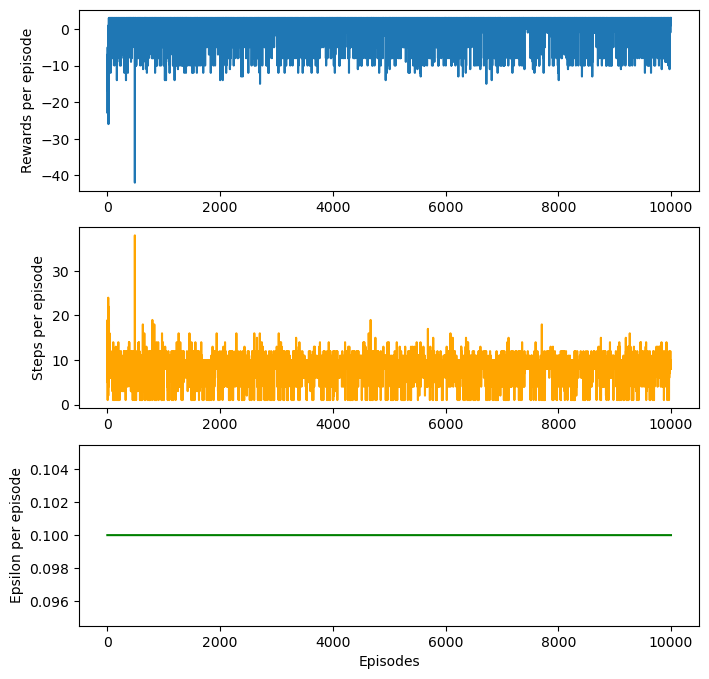

In [7]:
FL_1.plot_results()

# Combination 2

* Learning rate as 0.5
* Discount rate as 0.9
* Epsilon as 0.10 (with Decay rate of 0.01)

In [8]:
episodes = 10000
alpha = 0.5
gamma = 0.9
epsilon = 0.10
    
FL_2 = FrozenLake(alpha = alpha, gamma = gamma, epsilon = epsilon, decay = True)
FL_2.q_lr(episodes)
FL_2.show_values()

----------------------------------------------
| -0.434 | 0.629  | 1.81   | -2.004 | 1.506  | 
----------------------------------------------
| 0.0    | 1.81   | 3.122  | 0.0    | 6.098  | 
----------------------------------------------
| -1.68  | 3.122  | 4.58   | 6.2    | 8.0    | 
----------------------------------------------
| -1.482 | 0.0    | 6.2    | 8.0    | 10.0   | 
----------------------------------------------
| -1.561 | -1.426 | 0.0    | 10.0   | 0.0    | 
----------------------------------------------


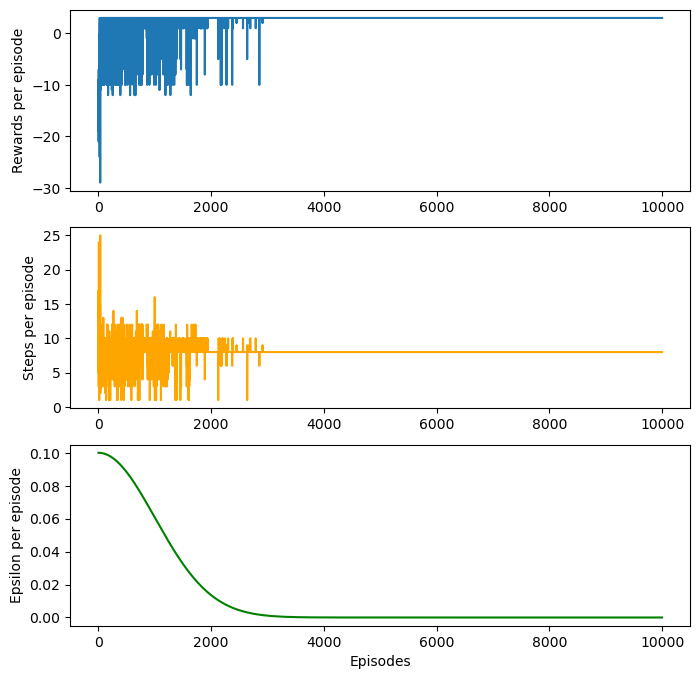

In [9]:
FL_2.plot_results()

# Combination 3

* Learning rate as 0.8
* Discount rate as 0.95
* Constant epsilon as 0.05 (with Decay rate as 0.001)

In [10]:
episodes = 10000
alpha = 0.5
gamma = 0.951
epsilon = 0.20
    
FL_3 = FrozenLake(alpha = alpha, gamma = gamma, epsilon = epsilon, decay = True, decay_rate=0.001)
FL_3.q_lr(episodes)
FL_3.show_values()

----------------------------------------------
| 0.984  | 2.086  | 3.245  | 4.464  | 5.745  | 
----------------------------------------------
| 0.0    | 3.245  | 4.464  | 0.0    | 7.093  | 
----------------------------------------------
| 3.245  | 4.464  | 5.745  | 7.093  | 8.51   | 
----------------------------------------------
| 1.208  | 0.0    | 7.093  | 8.51   | 10.0   | 
----------------------------------------------
| -1.928 | -1.928 | 0.0    | 10.0   | 0.0    | 
----------------------------------------------


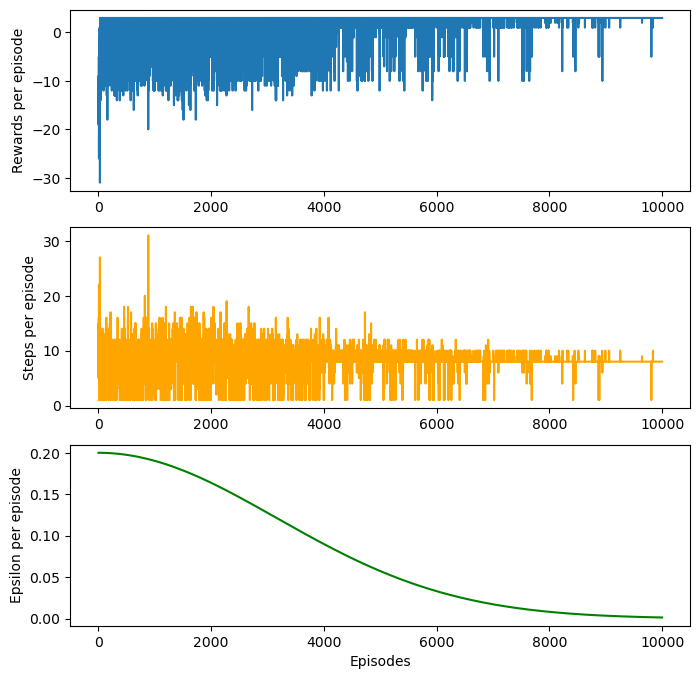

In [11]:
FL_3.plot_results()

### Results of each combinations are discussed in the PDF file.

<hr>